Importing necessary libraries

In [ ]:
!-m pip install pymongo
!pip install pickle-mixin 
!pip install bson
!pip install gridfs-fuse
!pip install Keras
!pip install -U scikit-learn
!pip install opencv-python
!pip install numpy
!-m pip install -U matplotlib

In [1]:
import pymongo
from pymongo import MongoClient
import pickle
import time
#grids library to save images into mongodb
from bson import ObjectId
import gridfs

<h2>HELPING FUNCTIONS</h2>

Function to save training and testing data from CIFAR-10 into Mongodb

In [2]:
#function to save x_train, y_train , X_test and Y_test into db
def save_train_dataset(xy_dataset, client, db, trainName):
    
    #pickling the data
    pickled_model = pickle.dumps(xy_dataset)
    
    #creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongo
    mydb = myclient[db]
    
    #connection gridfs with db
    fs = gridfs.GridFS(mydb)
    
    objectID= fs.put(pickled_model, filename=trainName)
    print(objectID, ' saved with this id successfully!')
    details = {
        'inserted_id':objectID,
        'filename':trainName,
        'created_time':time.time()
    }
    
    return details

Function to load training and testing data from Mongodb

In [3]:
#funtion how to retrieve the a specific train data from the db e.i x_train
def load_train_dataset(trainName, client, db):
    
    #creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongo
    mydb = myclient[db]
    
    #connection gridfs with db
    fs = gridfs.GridFS(mydb)
    
    #fetching data from db
    file = fs.find_one({"filename": trainName})
    pickleFile = file.read()
    
    return pickle.loads(pickleFile)

Function to save our model into Mongodb

In [4]:
#function to save our model to mongodb
def save_model_to_db(model, client, db, model_name):
    #pickling the model
    
    pickled_model = pickle.dumps(model)
    
    #saving model to mongo
    #creating connection
    myclient = pymongo.MongoClient(client)
    
    #creating database in mongo
    mydb = myclient[db]
    
    #connection gridfs with db
    fs = gridfs.GridFS(mydb)
    
    objectID= fs.put(pickled_model, filename=model_name)
    print(objectID, ' saved with this id successfully!')
    details = {
        'inserted_id':objectID,
        'model_name':model_name,
        'created_time':time.time()
    }
    
    return details

Function to load our model from Mongodb

In [5]:
#function to retrieve model from mongodb
def load_model_from_db(model_name, client, db):
    
    #saving model to mongo
    #creating connection
    myclient = pymongo.MongoClient(client)
    
    #connecting to the db
    mydb = myclient[db]
    
    #connection gridfs with db
    fs = gridfs.GridFS(mydb)
    
    #fetching model from db, reading it
    file = fs.find_one({"filename": model_name})
    pickleFile = file.read()
    
    #loading pickle data
    return pickle.loads(pickleFile)

<h2>MODEL IMPLEMENTATION</h2>

Getting data from CIFAR-10

In [6]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [7]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [8]:
#Checking mongo version
print ('Mongo version', pymongo.__version__)

Mongo version 3.10.1


In [9]:
#creating the db
client = MongoClient('localhost', 27017)
db = client['project']
fs = gridfs.GridFS(db)

Saving training and testing data into Mongodb

In [10]:
#Store the data into db the x_train, y_train, X_test, Y_test
xDetails = save_train_dataset(xy_dataset = x_train, client ='mongodb://localhost:27017/', db = 'project', 
                trainName = 'XtrainSet')
yDetails = save_train_dataset(xy_dataset = y_train, client ='mongodb://localhost:27017/', db = 'project', 
                trainName = 'YtrainSet')
xTestDetails = save_train_dataset(xy_dataset = x_test, client ='mongodb://localhost:27017/', db = 'project', 
                trainName = 'XTestSet')
yTestDetails = save_train_dataset(xy_dataset = y_test, client ='mongodb://localhost:27017/', db = 'project', 
                trainName = 'YTestSet')

5eaace9997482a4e58bc3583  saved with this id successfully!
5eaace9a97482a4e58bc37d2  saved with this id successfully!
5eaace9a97482a4e58bc37d5  saved with this id successfully!
5eaace9a97482a4e58bc384d  saved with this id successfully!


Loading training and testing data from Mongodb to use in our model

In [11]:
x_train_final = load_train_dataset(trainName = xDetails['filename'], client = 'mongodb://localhost:27017/', 
                         db = 'project')
y_train_final = load_train_dataset(trainName = yDetails['filename'], client = 'mongodb://localhost:27017/', 
                         db = 'project')
x_test_final = load_train_dataset(trainName = xTestDetails['filename'], client = 'mongodb://localhost:27017/', 
                         db = 'project')
y_test_final = load_train_dataset(trainName = yTestDetails['filename'], client = 'mongodb://localhost:27017/', 
                         db = 'project')

<h2>Classification model</h2>

In [12]:
# The first step in training our network is to implement the network architecture itself in Keras
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

class ClModel:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape and channel dimension, assuming
        # TensorFlow/channels-last ordering
        inputShape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=inputShape)

# Let’s start defining the body of the Convolutional Neural Network:
        # first (CONV => RELU) * 2 => POOL layer set
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

# Let’s add the fully-connected (FC) layers to the network:
        # second (CONV => RELU) * 2 => POOL layer set
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # first (and only) set of FC => RELU layers
        x = Flatten()(x)
        x = Dense(512)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # softmax classifier
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="ClModel")

        # return the constructed network architecture
        return model

# Our FC and Softmax classifier are appended onto the network. 
# We then define the neural network model and return it to the calling function.

In [13]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [14]:
# scaling data into the range [0, 1]
trainX = x_train_final.astype("float") / 255.0
testX = x_test_final.astype("float") / 255.0

In [15]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(y_train_final)
testY = lb.transform(y_test_final)

In [16]:
# CIFAR-10 contains 10 classes of images let’s make a list of these classes
labels = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [22]:
# Next, let’s train the model
# initialize the initial learning rate, total number of epochs to train for, and batch size
LR = 0.01
EPOCHS = 30
BS = 32

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr = LR, decay= LR / EPOCHS)
model = ClModel.build(width=32, height=32, depth=3, classes=len(labels))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
time1 = time.time()   # measure the time taken
history = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=BS, epochs=EPOCHS, verbose=1)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # measure the time taken

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

[INFO] compiling model...
[INFO] training network for 30 epochs...
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 233s 5ms/step - loss: 1.7766 - accuracy: 0.4093 - val_loss: 1.6932 - val_accuracy: 0.4212
Epoch 2/30
50000/50000 [==============================] - 232s 5ms/step - loss: 1.2961 - accuracy: 0.5321 - val_loss: 1.2481 - val_accuracy: 0.5592
Epoch 3/30
50000/50000 [==============================] - 2292s 46ms/step - loss: 1.1561 - accuracy: 0.5878 - val_loss: 1.2366 - val_accuracy: 0.5559
Epoch 4/30
50000/50000 [==============================] - 239s 5ms/step - loss: 1.0740 - accuracy: 0.6200 - val_loss: 1.0076 - val_accuracy: 0.6407
Epoch 5/30
50000/50000 [==============================] - 265s 5ms/step - loss: 1.0188 - accuracy: 0.6385 - val_loss: 0.9764 - val_accuracy: 0.6568
Epoch 6/30
50000/50000 [==============================] - 236s 5ms/step - loss: 0.9786 - accuracy: 0.6528 - val_loss: 1.0565 - val_accuracy: 

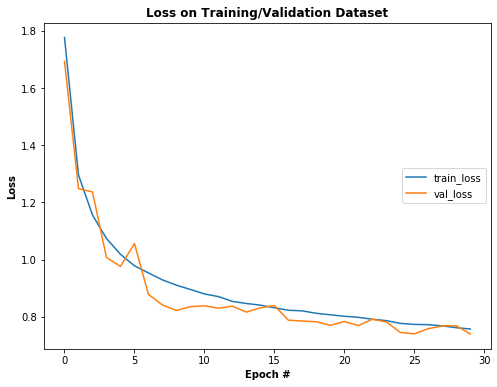

In [23]:
# plot the training/validation loss
plt.figure(figsize = [8,6])
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Loss on Training/Validation Dataset", weight="bold")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend(loc="right");

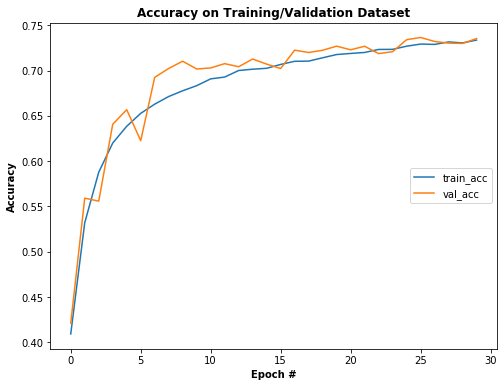

In [24]:
# plot the training/validation accuracy
plt.figure(figsize = [8,6])
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on Training/Validation Dataset", weight="bold")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend(loc="right");

In [25]:
model.summary()

Model: "ClModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128 

Save the model into Mongodb

In [26]:
saved_model = save_model_to_db(model = model, client ='mongodb://localhost:27017/', db = 'project', model_name = 'model')

5eab0e1797482a4e58bc3854  saved with this id successfully!


In [27]:
print(saved_model)

{'inserted_id': ObjectId('5eab0e1797482a4e58bc3854'), 'model_name': 'model', 'created_time': 1588268567.275678}


Load the model and predict

In [28]:
#loading model from mongo
model = load_model_from_db(model_name = saved_model['model_name'], client = 'mongodb://localhost:27017/', 
                         db = 'project' )

Text(0, 0.5, 'Category')

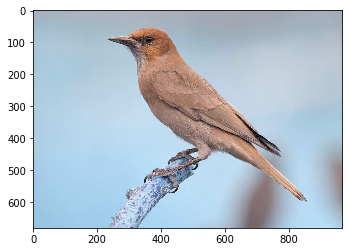

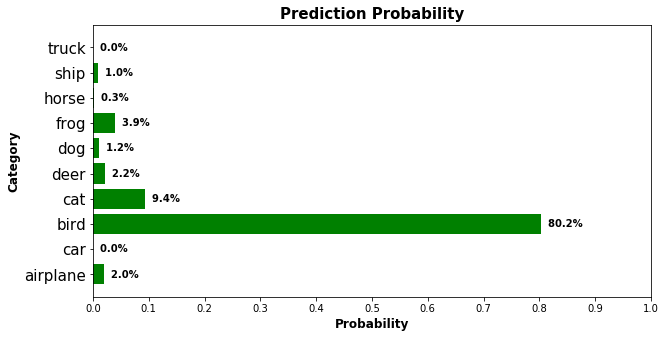

In [35]:
import cv2

# load the input image and resize it to the target spatial dimensions
image = cv2.imread("bird.jpg")
plt.imshow(image)
image = cv2.resize(image, (32, 32))   # height, width

# scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

# when working with a CNN: don't flatten the image, simply add the batch dimension (expected input to have 4 dimensions)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# make a prediction on the image
preds = model.predict(image)

# plot the prediction probability for each category
plt.figure(figsize = [10,5])

x = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
y = [ preds[0][0], preds[0][1], preds[0][2], preds[0][3], preds[0][4], preds[0][5], preds[0][6], preds[0][7], preds[0][8], preds[0][9] ]
plt.barh(x, y, color='g')

ticks_x = np.linspace(0, 1, 11)   # (start, end, # of ticks)
plt.xticks(ticks_x, fontsize=10)
plt.yticks( size=15 )
for i, v in enumerate(y):
    plt.text(v, i, "  "+str((v*100).round(1))+"%", va='center', fontweight='bold')

plt.title('Prediction Probability', fontsize=15, weight='bold', loc='center', rotation=0)
plt.xlabel('Probability', fontsize=12, weight='bold')
plt.ylabel('Category', fontsize=12, weight='bold')